## Commodity Data Exploration and Analysis

In this file I will perform some data exploration and analysis of the commodity data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
commodity_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\commodity_list.csv', header=None, index_col=0)
county_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\counties.csv', header=0, index_col=0)
population_set = pd.read_csv('Z:\\Asus Documents\\PythonProgramming\\mdBest\\maryland_population.csv', header=0)

In [2]:
county_set.index.rename("seller_id", inplace=True)
commodity_set.index.rename("seller_id", inplace=True)

### Location/County Data

In [3]:
# Clean up the county set
county_set = county_set.rename(columns={"1":"Address", "2": "Coordinates", "3": "Jurisdiction"})

In [4]:
county_set.groupby('Jurisdiction').size()

Jurisdiction
Allegany County            4
Anne Arundel County       19
Baltimore City            22
Baltimore County          42
Calvert County            11
Caroline County            8
Carroll County            26
Cecil County              10
Charles County             8
Dorchester County          5
Frederick County          30
Garrett County             7
Harford County            19
Howard County             13
Kent County                6
Montgomery County         32
New Castle County          1
Prince George's County    24
Queen Anne's County       14
Somerset County            2
St. Mary's County          6
Talbot County              7
Washington County         17
Wicomico County            8
Worcester County           6
dtype: int64

Interestingly, a single Delaware entry was included- from New Castle County. There are at least two records from every Maryland jurisdiction though.

In [5]:
county_set[(county_set['Jurisdiction'] == 'New Castle County')]

,Address,Coordinates,Jurisdiction
seller_id,,,
34,"Rt 40 & 896, Bear, DE \n","39.6056676, -75.74132559999998",New Castle County


Because the record is not in the target group, the Delaware record will be removed.

In [6]:
county_set = county_set.drop(34)
commodity_set = commodity_set.drop(34)

In [7]:
county_group = county_set.groupby('Jurisdiction', as_index=False).size()

<AxesSubplot:xlabel='Jurisdiction'>

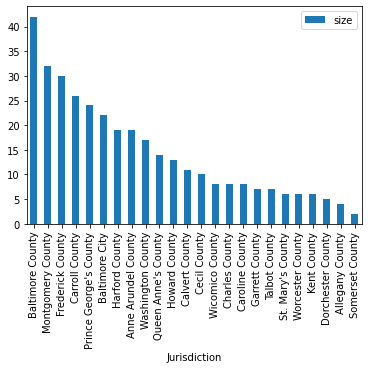

In [8]:
county_group.sort_values('size',ascending = False).plot(kind = 'bar', x = 0, y = 1)

#### Commodity Records by Jurisdiction

Just by the distribution of records by county there appears to be a variation based on population, but the spread of commodity records appears to have a more even spread than that of the State's population. Population per county data from the [Maryland Department of Planning](https://planning.maryland.gov/MSDC/Pages/pop_estimate/popest_cnty.aspx) is shown below.

In [9]:
population_set = population_set.rename(columns={' State/Jurisdiction ': 'State/Jurisdiction'})

<AxesSubplot:xlabel='State/Jurisdiction'>

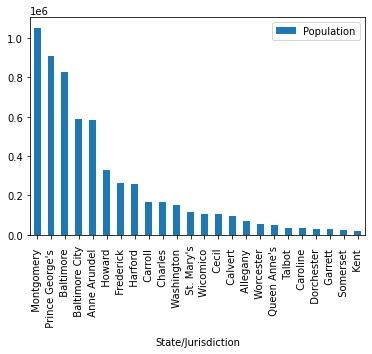

In [10]:
population_set.sort_values(by = 'Population', ascending = False).plot(kind = 'bar', x = 0, y = 1)

#### Population by Jurisdiction

Below, the connection between population and the number of commodity records is explored using variance analysis.

In [11]:
# Match the jurisdiction names
population_set.loc[~population_set['State/Jurisdiction'].str.contains('City'), 'State/Jurisdiction'] = population_set['State/Jurisdiction'] + 'County'

In [12]:
county_group = county_group.rename(columns={'size': 'commodity_count'})

In [13]:
county_group['Jurisdiction'] = county_group['Jurisdiction'].str.strip()
county_group['Jurisdiction'] = county_group['Jurisdiction'].str.upper()
population_set['State/Jurisdiction'] = population_set['State/Jurisdiction'].str.strip()
population_set['State/Jurisdiction'] = population_set['State/Jurisdiction'].str.upper()

population_set['State/Jurisdiction']  = population_set['State/Jurisdiction'].str.replace('  ', ' ')

In [14]:
jurisdiction_commodity = county_group.merge(right=population_set, left_on='Jurisdiction', right_on='State/Jurisdiction')

In [15]:
jurisdiction_commodity = jurisdiction_commodity.drop(columns=['State/Jurisdiction'])

In [16]:
jurisdiction_commodity['commodity_count'].corr(jurisdiction_commodity['Population'], 'pearson')

0.7968177395398512

Pearon's correlation coefficient confirms that population by jurisdiction is highly correlated to the number of commodity entries.

It is likely that the difference between the distribution is at least in part due to the fact that jurisdictions in Maryland with smaller populations have much more farmland.

### Commodity Count Exploration

How many unique item entries exist?

In [17]:
# Add unique values from each column.
commodity_cols = commodity_set.columns
for i in range(len(commodity_cols)):
    if i == 0:
        commodities = commodity_set[commodity_cols[i]].unique()
    else:
        commodities = np.concatenate((commodities, commodity_set[commodity_cols[i]].unique()), axis=0)
        
# Convert to series and group.
commodities = pd.Series(commodities)
commodities = commodities.groupby(commodities).size()
len(commodities)

178

In [18]:
commodities.sort_values(ascending=False).head(15)

Tomatoes          49
Vegetables        45
Conventional      43
Squash            42
Watermelons       39
Zucchini          38
Sweet-peppers     38
Lettuce           37
Pumpkins          37
Potatoes          36
Sweet-corn        36
Melons            35
Spinach           34
Strawberries      34
Sweet-potatoes    34
dtype: int64

In [19]:
# Convert to dataframe.
commodities = pd.DataFrame(commodities)
commodities = commodities.reset_index()
commodities = commodities.rename(columns={"index": "commodity", 0:"count"})

Although there are 178 unique items, not all of them have much value information-wise, with some of the most common being 'Conventional' and 'Vegetables'. Because this list is not an overbearing number it can be checked manually. A category for each commodity will be established at this time as well.

In [20]:
# Checked manually and read in:
import csv
to_remove = list()
with open ("commodities_to_remove.csv", "r") as remove_read:
    reader = csv.reader(remove_read)
    for row in reader:
        to_remove.extend(row)
        
commodities  = commodities.loc[~commodities["commodity"].isin(to_remove)].copy()
len(commodities)

156

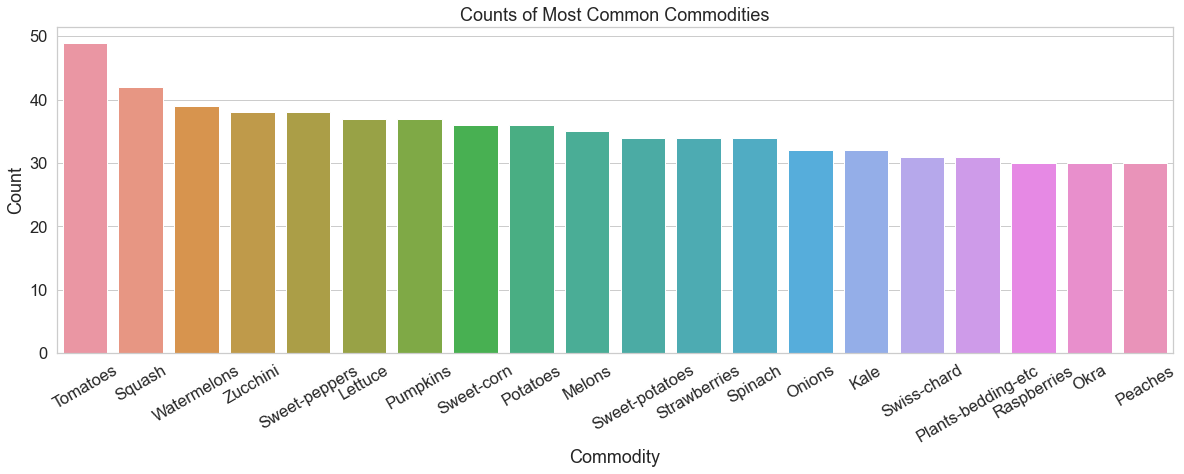

In [21]:
top_commodities = commodities.sort_values("count", ascending = False).head(20)
top_commodities["count"] = top_commodities["count"].astype("int")

sns.set_theme(rc = {"figure.figsize":(20,6)}, style="whitegrid", font_scale=1.5)

p = sns.barplot(data=top_commodities, x="commodity", y="count", hue=None)

p.set_xlabel("Commodity")
p.set_ylabel("Count")
p.set_title("Counts of Most Common Commodities")
plt.xticks(rotation = 30)
plt.show()

In [22]:
commodities["count"].describe()

count    156.000000
mean      13.955128
std       11.166391
min        1.000000
25%        5.000000
50%       11.000000
75%       20.250000
max       49.000000
Name: count, dtype: float64

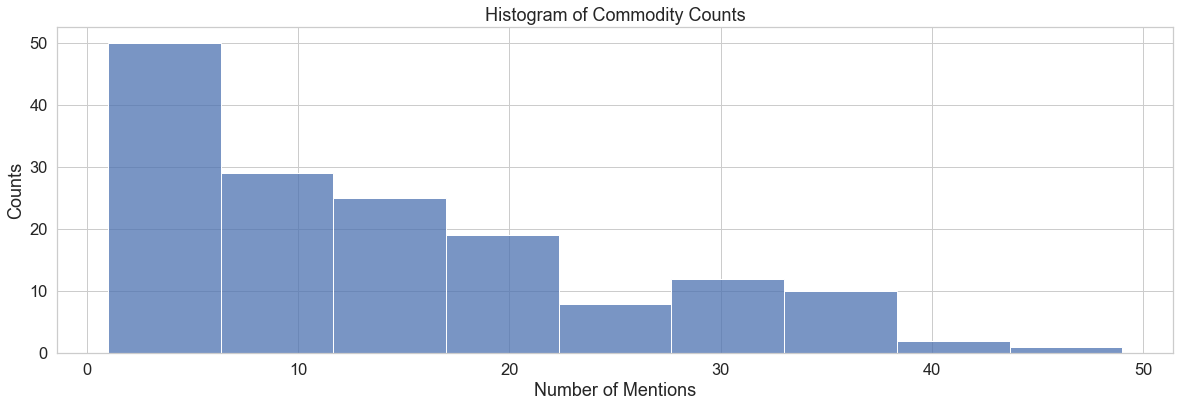

In [23]:
p = sns.histplot(commodities["count"])

p.set_xlabel("Number of Mentions")
p.set_ylabel("Counts")
p.set_title("Histogram of Commodity Counts")
plt.show()

It appears that the majority of commodities are represented only a few time, with a quick drop off in counts before the few outliers that were mentioned above.

### Next Steps

There are a few more questions that can be explored:

-What is the relationship between commodity category and jurisdiction?

-What is the correlation between commodities and census tracts?

In [24]:
# One-hot encode the commodity data.
commodity_vals = commodity_set.values.tolist()
commodity_index = commodity_set.index.tolist()
unique_commodities = commodities["commodity"].tolist()

list_of_sellers = list()
for i in range(len(commodity_index)):
    temp_list = list()
    for j in unique_commodities:
        if j in commodity_vals[i]:
            temp_list.append(1)
        else:
            temp_list.append(0)
    list_of_sellers.append(temp_list)
    
commodity_encoded = pd.DataFrame(list_of_sellers, index = commodity_index, columns=unique_commodities)

In [25]:
# Normalize the commodity data.
seller_ids = list()
commodity_long = list()
for i in range(len(commodity_index)):
    for j in commodity_vals[i]:
        if not pd.isnull(j) and j in unique_commodities:
            seller_ids.append(commodity_index[i])
            commodity_long.append(j)
            
commodity_norm = pd.DataFrame(list(zip(seller_ids, commodity_long)), columns=["seller_id", "commodity"])

In [26]:
# Join with geographical information.
commodity_norm = commodity_norm.merge(right=county_set, on="seller_id")

In [27]:
# Read in the established category for each commodity.
commodity_category = pd.read_csv("commodity_categories.csv", header=None)
commodity_category = commodity_category.rename(columns={0:"commodity", 1:"category"})

In [28]:
# Join with the data.
commodity_norm = commodity_norm.merge(right=commodity_category, on="commodity")

In [29]:
# Find the most common category for each jurisdiction.
c_j_group = commodity_norm.groupby(["Jurisdiction", "category"], as_index=False).size()

c_j_outer = c_j_group.groupby("Jurisdiction", as_index=False)["size"].max()

c_j_outer.merge(right=c_j_group, on=["Jurisdiction", "size"])

,Jurisdiction,size,category
0,Allegany County,1,processed
1,Anne Arundel County,80,vegetables
2,Baltimore City,90,vegetables
3,Baltimore County,237,vegetables
4,Calvert County,42,vegetables
5,Caroline County,48,vegetables
6,Carroll County,35,vegetables
7,Cecil County,39,vegetables
8,Charles County,98,vegetables
9,Dorchester County,15,vegetables


The uncommon counties for this data are Allegany County with Processed commodities, Kent County with Fruit, and Washington County with livestock.

In [30]:
c_j_group.dtypes

Jurisdiction    object
category        object
size             int64
dtype: object

In [31]:
# Pivot data.
c_j_pivot = c_j_group.pivot("Jurisdiction", "category", "size")
# clean display
c_j_pivot = c_j_pivot.fillna("")
for col in c_j_pivot.columns.tolist():
    c_j_pivot[col] = c_j_pivot[col].astype(str).apply(lambda x: x.replace(".0",""))
    
c_j_pivot

category,dairy,fishing,fruit,grain,leafy greens,livestock,nuts,plant,processed,vegetables
Jurisdiction,,,,,,,,,,
Allegany County,,,,,,,,,1,
Anne Arundel County,,,28,5,15,4,,18,3,80
Baltimore City,3,1,18,2,20,21,2,4,9,90
Baltimore County,4,2,55,19,45,40,,31,13,237
Calvert County,6,,17,3,10,21,,5,5,42
Caroline County,,,17,3,9,1,,1,3,48
Carroll County,4,,12,1,5,9,,9,7,35
Cecil County,6,1,16,8,7,7,,18,5,39
Charles County,3,2,38,12,21,19,,20,8,98
